In [32]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [33]:
base_url = "https://api.binance.com/api/v3"

In [34]:
def get_klines(symbol, interval, start_time, end_time):
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": int(start_time.timestamp() * 1000),
        "endTime": int(end_time.timestamp() * 1000),
        "limit": 1000  # Maximum number of data points per request (adjust as needed)
    }
    response = requests.get(f"{base_url}/klines", params=params)
    data = response.json()
    df = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "num_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    df["open"] = df["open"].astype('float')
    df["close"] = df["close"].astype('float')
    df["high"] = df["high"].astype('float')
    df["low"] = df["low"].astype('float')
    return df

def calculate_ma(data, period=20):
    return data["close"].rolling(window=period).mean()

def analyze_price_movements(df, ma20):
    df["ma20"] = ma20
    df["ma20_cross_above"] = (df["close"] > df["ma20"]) & (df["close"].shift(1) <= df["ma20"].shift(1))
    df["ma20_cross_below"] = (df["close"] < df["ma20"]) & (df["close"].shift(1) >= df["ma20"].shift(1))

    # Initialize columns for valid breakout and valid breakdown
    df["valid_breakout"] = False
    df["valid_breakdown"] = False
    df["max_price_change"] = 0.0
    df["closing_price_change"] = 0.0

    # Calculate valid breakout and valid breakdown
    for index, row in df.iterrows():
        if row["ma20_cross_above"]:
            end_time = row["timestamp"] + pd.Timedelta(hours=24)
            valid_breakout = df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "close"] > df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "ma20"]
            if valid_breakout.all():
                df.loc[index, "valid_breakout"] = True

                max_high = df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "high"].max()
                df.loc[index, "max_price_change"] = (max_high - row["close"]) / row["close"] * 100
                df.loc[index, "closing_price_change"] = (df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "close"].iloc[-1] - row["close"]) / row["close"] * 100
        
        if row["ma20_cross_below"]:
            end_time = row["timestamp"] + pd.Timedelta(hours=24)
            valid_breakdown = df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "close"] < df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "ma20"]
            if valid_breakdown.all():
                df.loc[index, "valid_breakdown"] = True

                min_low = df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "low"].min()
                df.loc[index, "max_price_change"] = (min_low - row["close"]) / row["close"] * 100
                df.loc[index, "closing_price_change"] = (df.loc[(df["timestamp"] > row["timestamp"]) & (df["timestamp"] <= end_time), "close"].iloc[-1] - row["close"]) / row["close"] * 100

    return df



def plot_ma(klines_data):
    plt.figure(figsize=(12, 6))
    plt.plot(klines_data["timestamp"], klines_data["close"], label="Close", color='blue')
    plt.plot(klines_data["timestamp"], klines_data["ma20"], label="MA20", color='red')

    # Plot valid breakout and breakdown bars
    for index, row in klines_data.iterrows():
        if row["valid_breakout"]:
            start_time = row["timestamp"]
            end_time = start_time + pd.Timedelta(hours=24)
            plt.scatter(row["timestamp"], row["close"], marker='^', color='green', s=100)
            plt.axvspan(start_time, end_time, alpha=0.2, color='green')
        if row["valid_breakdown"]:
            start_time = row["timestamp"]
            end_time = start_time + pd.Timedelta(hours=24)
            plt.scatter(row["timestamp"], row["close"], marker='v', color='red', s=100)
            plt.axvspan(start_time, end_time, alpha=0.2, color='red')

    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.title("Close and MA20 with 24-Hour Bars for Valid Breakouts and Breakdowns")
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
symbol = "BTCUSDT"
interval = "4h"
start_time = datetime(2023, 1, 1)
end_time = datetime(2023, 3, 15)

klines_data = get_klines(symbol, interval, start_time, end_time)
ma20 = calculate_ma(klines_data)
analyzed_data = analyze_price_movements(klines_data, ma20)

# Filter valid breakouts (closing price remains above/below MA20 for the next 24 hours)
valid_breakouts = analyzed_data[
    analyzed_data["valid_breakout"]|
    analyzed_data["valid_breakdown"]
]

In [36]:
# Task 1
task_1 = klines_data[['timestamp','open','high','low','close','volume']]
task_1.to_csv('task_1.csv')
task_1

,timestamp,open,high,low,close,volume
0,2022-12-31 16:00:00,16590.10,16613.30,16565.10,16570.14,16498.87510000
1,2022-12-31 20:00:00,16570.14,16574.97,16470.00,16542.40,17909.48676000
2,2023-01-01 00:00:00,16541.77,16559.77,16508.39,16533.04,15515.82327000
3,2023-01-01 04:00:00,16533.04,16550.00,16499.01,16526.19,16532.24115000
4,2023-01-01 08:00:00,16525.70,16557.00,16505.20,16556.66,15915.96701000
...,...,...,...,...,...,...
434,2023-03-14 00:00:00,24112.27,24496.41,23986.02,24374.20,70241.14758000
435,2023-03-14 04:00:00,24375.68,24820.00,24139.06,24247.64,78968.84513000
436,2023-03-14 08:00:00,24246.75,24820.00,24118.28,24743.04,90925.96183000
437,2023-03-14 12:00:00,24743.05,26386.87,24458.04,25894.67,210348.01513000


In [37]:
# Task 2 
print("Total:", len(analyzed_data[analyzed_data["ma20_cross_above"] | analyzed_data["ma20_cross_below"]]))
print("Valid:", len(valid_breakouts))

Total: 38
Valid: 17


In [38]:
# Task 3
task_3 = valid_breakouts[['timestamp','valid_breakout','valid_breakdown','max_price_change','closing_price_change']]
task_3.to_csv('task_3.csv')
task_3

,timestamp,valid_breakout,valid_breakdown,max_price_change,closing_price_change
35,2023-01-06 12:00:00,True,False,1.188659,0.591420
107,2023-01-18 12:00:00,False,True,-3.020426,-0.790249
119,2023-01-20 12:00:00,True,False,10.361900,8.768740
151,2023-01-25 20:00:00,True,False,0.960629,-0.222411
159,2023-01-27 04:00:00,True,False,1.851663,-0.352190
178,2023-01-30 08:00:00,False,True,-2.502311,-0.918818
192,2023-02-01 16:00:00,True,False,3.715943,1.781323
204,2023-02-03 16:00:00,False,True,-0.443496,0.505835
233,2023-02-08 12:00:00,False,True,-2.267242,-1.142606
267,2023-02-14 04:00:00,True,False,2.529345,1.568369


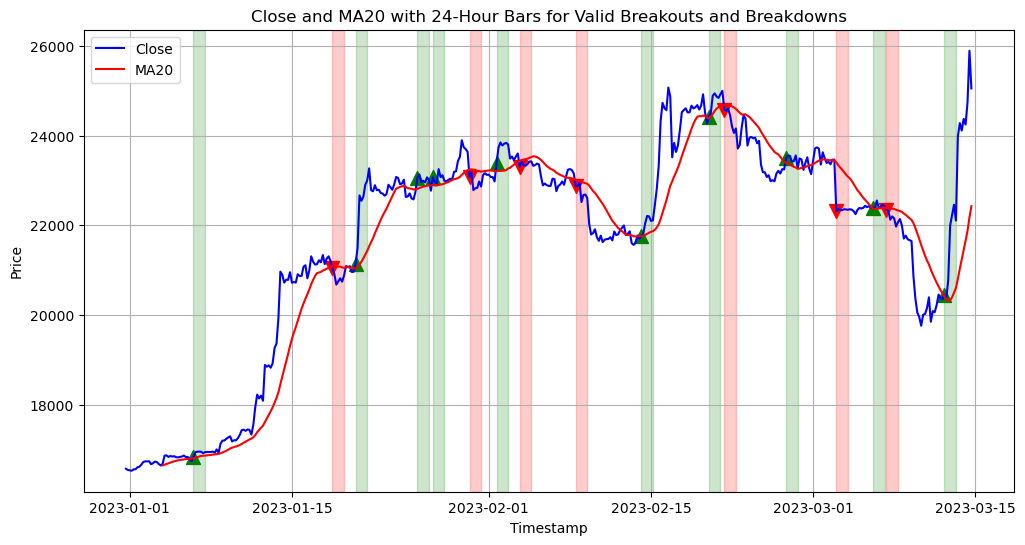

In [39]:
plot_ma(klines_data)